In [1]:
import dns
import numpy as np
from pathlib import Path
from scipy import optimize as opt
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
Ry = True
dt = 0.1
statesdir = Path("/home/gokhan/projects/dnsbox/re180Lx24Lz8")
savedir = Path("/home/gokhan/projects/dnsbox/slicetest")
states = sorted(list(statesdir.glob("state.*")))

In [3]:
state_, header_ = dns.readState(states[0])
forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt, itime, time = header_
ny_half = ny // 2

In [4]:
if Ry and ny_half % 2 != 0:
    exit("Ry but ny_half is not even.")

In [5]:
if Ry:
    ny_half_eff = ny_half // 2
else:
    ny_half_eff = ny_half

projections_x = np.zeros((len(states), ny_half_eff, 3), dtype=np.complex128)
projections_z = np.zeros((len(states), ny_half_eff, 3), dtype=np.complex128)

In [6]:
times = []
for istate in range(len(states)):
    if istate % 100 == 0:
        print(istate, len(states))
    state, header = dns.readState(states[istate])
    forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt_, itime, time = header
    times.append(time)
    if Ry:
        # u component, only even modes
        # x template
        projections_x[istate, :, 0] = state[1,:,0,0][::2]
        # z template
        projections_z[istate, :, 0] = state[0,:,1,0][::2]
        
        # v component, only odd modes
        # x template
        projections_x[istate, :, 1] = state[1,1:,0,1][::2]
        # z template
        projections_z[istate, :, 1] = state[0,1:,1,1][::2]
        
        # w component, only even modes
        # x template
        projections_x[istate, :, 2] = state[1,:,0,2][::2]
        # z template
        projections_z[istate, :, 2] = state[0,:,1,2][::2]

    else:
        # x template
        projections_x[istate, :, :] = state[1,:,0,:]
        # z template
        projections_z[istate, :, :] = state[0,:,1,:]

0 10001
100 10001
200 10001
300 10001
400 10001
500 10001
600 10001
700 10001
800 10001
900 10001
1000 10001
1100 10001
1200 10001
1300 10001
1400 10001
1500 10001
1600 10001
1700 10001
1800 10001
1900 10001
2000 10001
2100 10001
2200 10001
2300 10001
2400 10001
2500 10001
2600 10001
2700 10001
2800 10001
2900 10001
3000 10001
3100 10001
3200 10001
3300 10001
3400 10001
3500 10001
3600 10001
3700 10001
3800 10001
3900 10001
4000 10001
4100 10001
4200 10001
4300 10001
4400 10001
4500 10001
4600 10001
4700 10001
4800 10001
4900 10001
5000 10001
5100 10001
5200 10001
5300 10001
5400 10001
5500 10001
5600 10001
5700 10001
5800 10001
5900 10001
6000 10001
6100 10001
6200 10001
6300 10001
6400 10001
6500 10001
6600 10001
6700 10001
6800 10001
6900 10001
7000 10001
7100 10001
7200 10001
7300 10001
7400 10001
7500 10001
7600 10001
7700 10001
7800 10001
7900 10001
8000 10001
8100 10001
8200 10001
8300 10001
8400 10001
8500 10001
8600 10001
8700 10001
8800 10001
8900 10001
9000 10001
9100 10001


In [7]:
def find_shift(projection):
    shift = (np.arctan2(projection.imag, projection.real) / (2 * np.pi)) % 1
    return shift

def find_dphases(projections):
    shifts = find_shift(projections)
    phases = np.unwrap(shifts * 2 * np.pi)
    dphases = (phases[1:] - phases[:-1]) / dt
    return dphases

def constraint_unit_template(coeffs):
    return np.sqrt(np.sum(coeffs**2))

def maximize_average(coeffs_ravel, projs):
    res = np.einsum("ijk,jk", projs, np.reshape(coeffs_ravel, (ny_half_eff, 3)), dtype=np.complex128)
    abs_res = np.abs(res)
    return -np.sqrt(np.average(abs_res**2))

In [23]:
def optimal_template(projections,str_projections,verbose=1,maxiter=10000):
    
    tag = f"{str_projections}"
    print(tag)
    
    nstates, ny_half_eff, nc = projections.shape
    
    # start with all coefficients equal
    x0 = np.ravel(np.ones((ny_half_eff,3))/np.sqrt(ny_half_eff*nc))
    constraints = opt.NonlinearConstraint(constraint_unit_template,1,1)
    
    # run the optimization
    opts = opt.minimize(maximize_average,x0,args=(projections,),method="trust-constr",
                        constraints=constraints,
                        options={"verbose": verbose, "maxiter": maxiter})
    coeffs = np.reshape(opts.x, (ny_half_eff, 3))
    
    # save coefficients
    np.savetxt(savedir / f"coeffs_{tag}.gp", coeffs)
    
    # save template
    template = np.zeros((nx, ny_half, nz, 3), dtype=np.complex128)
    if str_projections == "x":
        ix = 1
        iz = 0
    elif str_projections == "z":
        ix = 0
        iz = 1
    else:
        exit("wrong str_projections.")

    for iy in range(ny_half):
        if Ry:
            if iy % 2 == 0:
                template[ix,iy,iz,0] = coeffs[iy // 2,0]
                template[ix,iy,iz,2] = coeffs[iy // 2,2]
            else:
                template[ix,iy,iz,1] = coeffs[iy // 2,1]
        else:
            template[ix,iy,iz,:] = coeffs[iy,:]
        
        # obey hermiticity
        if iy == 0:
            template[-ix,0,-iz,:] = np.conj(template[ix,0,iz,:])
            
    dns.writeState_nocompact(template,forcing=forcing,Lx=Lx,Lz=Lz,Re=Re,tilt_angle=tilt_angle,dt=dt,
                   outFile = savedir / f"u_{str_projections}p.000000")

    projections_opt = np.einsum("ijk,jk",projections,coeffs,dtype=np.complex128)
    abs_projections_opt = np.abs(projections_opt)
    shifts = find_shift(projections_opt)
    phases = np.unwrap(shifts * 2 * np.pi)
    dphases = (phases[1:] - phases[:-1]) / dt

    fig, ax = plt.subplots()
    ax.plot(times, np.abs(projections_opt))
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$|p_{str_projections}|$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"p{tag}.png", bbox_inches="tight")

    # Plot phases
    fig, ax = plt.subplots()
    ax.plot(times, phases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\phi_{str_projections}$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"phase_{tag}.png", bbox_inches="tight")

    # Plot phase derivatives
    fig, ax = plt.subplots()
    ax.plot(times[:-1], dphases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\dot{{\\phi_{str_projections}}}$")
    ax.set_xlim(left=times[0], right=times[-2])
    ax.set_xlim(600,900)
    fig.savefig(savedir / f"dphase_{tag}.png", bbox_inches="tight")
    
    plt.show()

x


/home/gokhan/usr/local/miniconda/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 99, function evaluations: 2535, CG iterations: 197, optimality: 9.56e-09, constraint violation: 0.00e+00, execution time:  2.4 s.


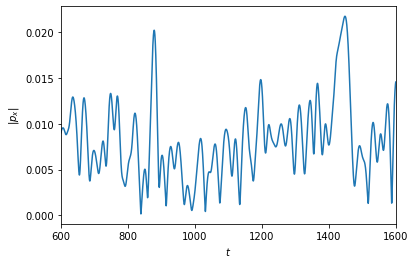

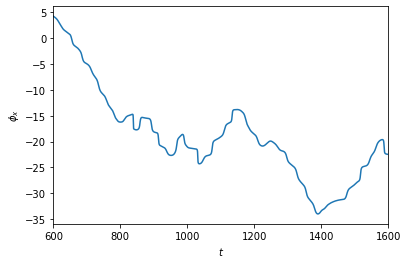

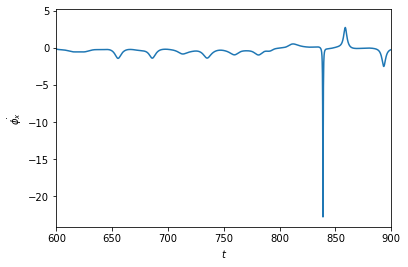

z
`gtol` termination condition is satisfied.
Number of iterations: 17, function evaluations: 312, CG iterations: 16, optimality: 2.33e-09, constraint violation: 6.02e-14, execution time: 0.18 s.


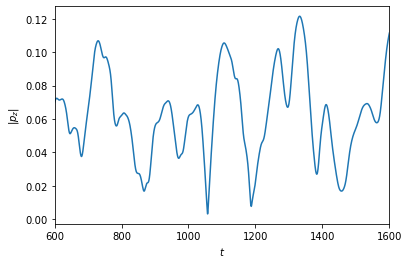

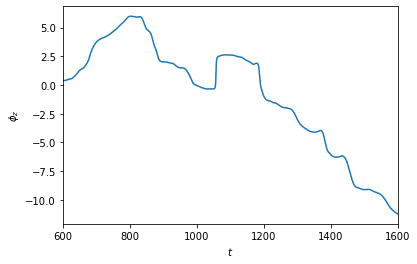

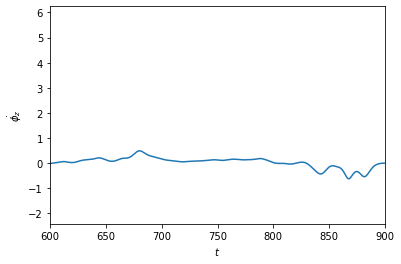

In [24]:
optimal_template(projections_x,"x")
optimal_template(projections_z,"z")

In [18]:
phases_dns = np.loadtxt("/home/gokhan/projects/dnsbox/re180Lx24Lz8/redo/phases.gp")

(0.0, 300.0)

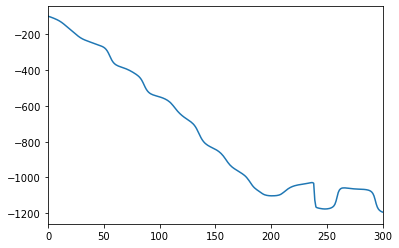

In [25]:
fig, ax = plt.subplots()
ax.plot(phases_dns[:-1,1], (np.unwrap(phases_dns[1:,2]) - np.unwrap(phases_dns[:-1,2])/dt))
ax.set_xlim(0,300)